# Dog Breed Classification

## Introduction

[ImageNet](https://www.image-net.org/) is one of the most popular datasets in computer vision, used mainly for image classification and localisation. Due to its vast size, subsets of this dataset can also be constructed to focus on specific problems. One such dataset is the [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data), containing images of several breeds of dogs, designed for fine-grained image categorisation.

In this assignment, you will be constructing and training neural network-based models to identify the breed of the dog shown in an image. Therefore, the models that will be considered fall under the category of object recognition. Hence, many concepts in related fields (e.g. face recognition) are also applicable here.

**Acknowledgements**

The original data source can be found at http://vision.stanford.edu/aditya86/ImageNetDogs/.

*⚠️ NOTE: The link does not use https to establish a secure connection and thus you may get a security warning if you attempt to access it. Instructions on how to use the dataset will be given below.*

**Reference:**

  Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

**ImageNet Reference:**

  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.

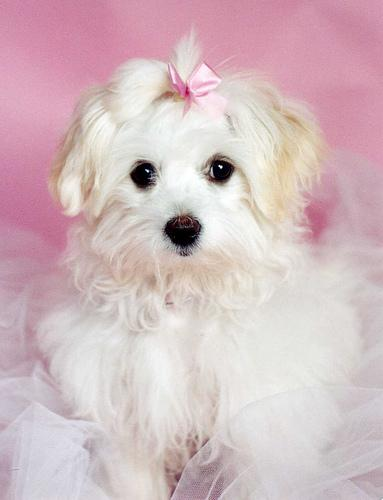

## Instructions
- The dataset is available by accessing the MECC storage (via Networks labs PCs), at `/opt/nfs/shared/images/ImageNetDogs`. The files and folders of interest are as follows:
 - **Images**: Image files
 - **Annotation**: Annotation files, containing metadata such as bounding boxes around the dog in the image
 - **README.txt**: Some information on the dataset

 *⚠️ NOTE: For this assignment, you DO NOT need to use any other files, such as file_list.mat, test_data.mat, etc.*

- This assignment is to be attempted individually.

- All code needs to be developed in Python 3. This Jupyter notebook should be used, and uploaded to the VLE once complete.

- Computers in the Networks lab can be used to train the models required to complete this assignment. It is HIGHLY recommended to use the GPUs.

- Any textual or visual information and equations that might need to be conveyed is expected to be written using the Markdown language.

- The Jupyter notebook to be submitted should be named as follows:

  `name-surname-idnumber.ipynb`

- The list of packages that are allowed for this assignment are as follows: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `xml`, `PIL`, `torchvision` and any other packages agreed with the lecturer.

- If you use any information or material from books, papers, websites, etc., please ensure that the appropriate citations are included.

- The deadline for this assignment is **Friday, 17th January 2025 at 15:00**.

## Package Imports

Import all of the packages required in the notebook

In [1]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms
from torchsummary import summary

In [2]:

TRAIN_SPLIT = 0.70
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15

assert TRAIN_SPLIT + TEST_SPLIT + VAL_SPLIT == 1.0

RANDOM_SEED = 0

BATCH_SIZE = 32
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
# CUDA Setting
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA available: False
GPU Name: No GPU detected


## The Data

### **Q1: Dataset Exploration** ###

Explore the dataset, to determine the characteristics of the data that you're using. Write down any observations.

*ℹ️ NOTE: Feel free to display a few examples, to get an idea of the image characteristics. Observing and understanding the characteristics of a dataset should help you design an effective way to split your data and any precautions or considerations requred when constructing your models (e.g. identifying any issues that may arise, allowing you to take preventative action). Things you could check out include the image quality, resolution, total number of images, number of classes, distribution of the number of images per class, etc.*

**(5 marks)**

In [4]:
# Data Declarations

DATA_DIR = "./data/"
ANNOTATIONS_DIR = os.path.join(DATA_DIR, "Annotation")
IMAGES_DIR = os.path.join(DATA_DIR, "Images")

# Helper Function to verify directories
def invalidDir(dirPath: str) -> bool:
    """
    Given a path, dirPath, will return a boolean based on if path exists and is a directory.
    """
    return not (os.path.exists(dirPath) and os.path.isdir(dirPath))

# Verification for Data Declarations
if invalidDir(DATA_DIR):
    raise RuntimeError("The 'DATA_DIR' variable in Q1 is not valid and does not exist.")
if invalidDir(ANNOTATIONS_DIR):
    raise RuntimeError("The 'Annotation' directory is missing.")
if invalidDir(IMAGES_DIR):
    raise RuntimeError("The 'Images' directory is missing.")

In [5]:
# List objects for class directories and names.

# List containing all folder names (dog breeds/class).
classDirectories = [folder for folder in os.listdir(ANNOTATIONS_DIR) if os.path.isdir(os.path.join(ANNOTATIONS_DIR, folder))]

# List containing a human readable represntation of the folder names.
# Ex. "n02085620-Chihuahua" -> "CHIHUAHUA"
classNames = [" ".join(classDir.split("-")[1:]).replace("_", " ").upper() for classDir in classDirectories]

#### Analysis

In [6]:
# Statistics

# Total Number of Classes

numOfClasses = len(classDirectories)

print(f"Number of Classes:")
print(f"    {numOfClasses}")

# Number of Images in each Class

imagesPerClass = [len(os.listdir(os.path.join(IMAGES_DIR, folder))) for folder in classDirectories]

print(f"Number of Images in each Class:")
print(f"    [:10]:   {imagesPerClass[:10]}")
print(f"    Total:   {sum(imagesPerClass)}")
print(f"    Minimum: {np.min(imagesPerClass)}")
print(f"    Maximum: {np.max(imagesPerClass)}")
print(f"    Average: {np.mean(imagesPerClass):.2f}")

# Number of Dogs in each Class

dogsPerClass = [
    sum(len(ET.parse(os.path.join(ANNOTATIONS_DIR, folder, annotationFile)).findall('object'))
        for annotationFile in os.listdir(os.path.join(ANNOTATIONS_DIR, folder)))
    for folder in classDirectories
]

print(f"Number of Dogs in each Class:")
print(f"    [:10]:   {dogsPerClass[:10]}")
print(f"    Total:   {sum(dogsPerClass)}")
print(f"    Minimum: {np.min(dogsPerClass)}")
print(f"    Maximum: {np.max(dogsPerClass)}")
print(f"    Average: {np.mean(dogsPerClass):.2f}")

# Difference between number of Images and number of Dogs in each Class

diffPerClass = [dogsPerClass[i] - imagesPerClass[i] for i in range(len(dogsPerClass))]

print(f"Difference between number of Images and number of Dogs in each Class:")
print(f"    [:10]:   {diffPerClass[:10]}")
print(f"    Total:   {sum(diffPerClass)}")
print(f"    Minimum: {np.min(diffPerClass)}")
print(f"    Maximum: {np.max(diffPerClass)}")
print(f"    Average: {np.mean(diffPerClass):.2f}")

# Dimensions of Images in each Class

dimensions = []

for classDir in classDirectories:
    for annotationFile in os.listdir(os.path.join(ANNOTATIONS_DIR, classDir)):
        annotation = ET.parse(os.path.join(ANNOTATIONS_DIR, classDir, annotationFile))

        width = int(annotation.find('size/width').text)
        height = int(annotation.find('size/height').text)

        dimensions.append((width, height))

resolutions = [x * y for (x, y) in dimensions]
average_width = np.mean([x for (x, _) in dimensions])
average_height = np.mean([y for (_, y) in dimensions])

print(f"Dimensions of Images in each Class:")
print(f"    [:10]:   {dimensions[:10]}")
print(f"    Minimum: {dimensions[np.argmin(resolutions)]}")
print(f"    Maximum: {dimensions[np.argmax(resolutions)]}")
print(f"    Average: ({average_width:.2f}, {average_height:.2f})")

Number of Classes:
    120
Number of Images in each Class:
    [:10]:   [160, 252, 152, 155, 153, 153, 159, 150, 186, 153]
    Total:   20580
    Minimum: 148
    Maximum: 252
    Average: 171.50
Number of Dogs in each Class:
    [:10]:   [167, 264, 155, 170, 160, 162, 168, 162, 191, 169]
    Total:   22126
    Minimum: 151
    Maximum: 287
    Average: 184.38
Difference between number of Images and number of Dogs in each Class:
    [:10]:   [7, 12, 3, 15, 7, 9, 9, 12, 5, 16]
    Total:   1546
    Minimum: 0
    Maximum: 48
    Average: 12.88
Dimensions of Images in each Class:
    [:10]:   [(500, 383), (500, 375), (500, 334), (500, 375), (334, 500), (340, 500), (500, 355), (500, 375), (284, 500), (370, 500)]
    Minimum: (105, 100)
    Maximum: (3264, 2448)
    Average: (442.53, 385.86)


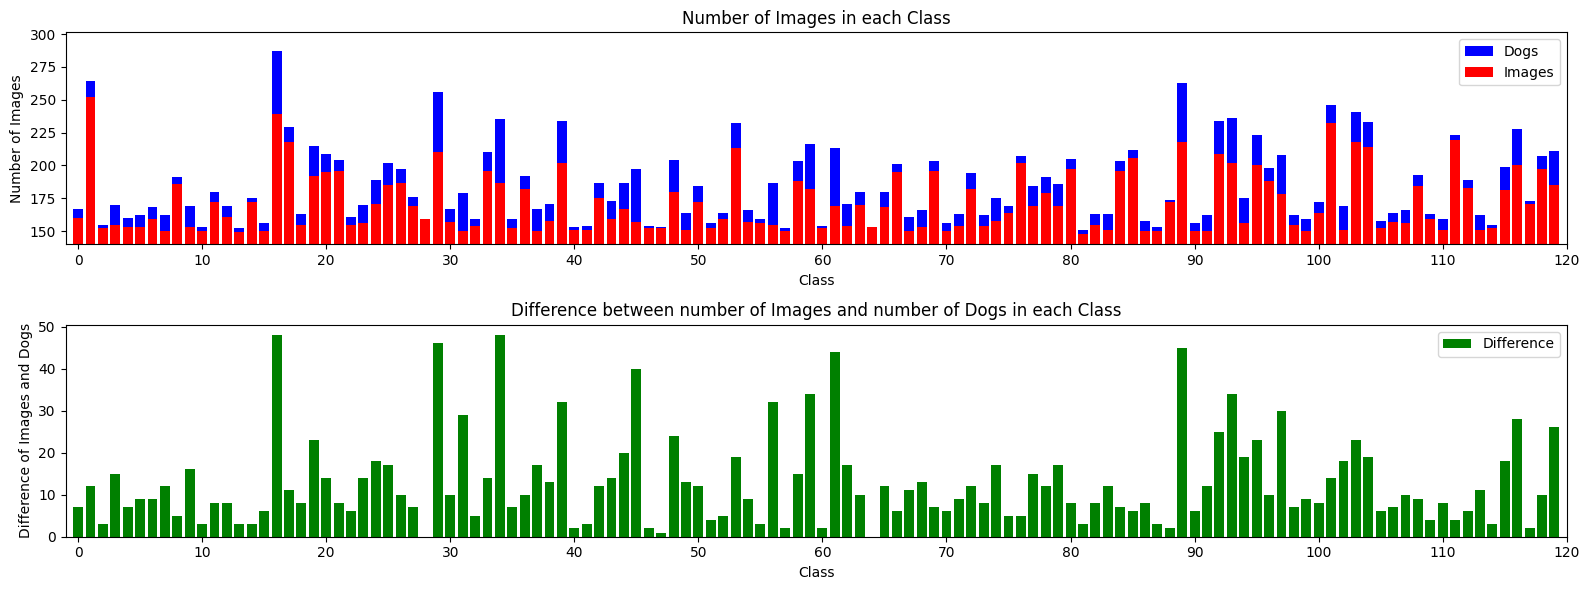

In [7]:
# Visualisation

plt.figure(figsize=(16,6))

plt.subplot(2,1,1)
minY = 10 * np.floor(np.min(imagesPerClass + dogsPerClass) / 10)
plt.title("Number of Images in each Class")
plt.bar(range(numOfClasses), dogsPerClass, color='blue', label='Dogs')
plt.bar(range(numOfClasses), imagesPerClass, color='red', label='Images')
plt.ylim(bottom=minY)
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xlim((-1,numOfClasses))
plt.xticks(range(0,numOfClasses+1,10))
plt.legend()

plt.subplot(2,1,2)
plt.title("Difference between number of Images and number of Dogs in each Class")
plt.bar(range(numOfClasses), diffPerClass, color='green', label='Difference')
plt.ylabel("Difference of Images and Dogs")
plt.xlabel("Class")
plt.xlim((-1,numOfClasses))
plt.xticks(range(0,numOfClasses+1,10))
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Sanity Checks

# Verify that all objects in all images contain only objects of that class.

print(f"All objects within an annotation file belong to the same class, in all classes: ", end="")

for classDir in classDirectories:
    classPath = os.path.join(ANNOTATIONS_DIR, classDir)
    for annotationFile in os.listdir(classPath):
        previous = ""
        annotation = ET.parse(os.path.join(classPath, annotationFile))
        for object in annotation.findall('object'):
            name = object.find('name').text
            if previous == "":
                previous = name
            elif previous != name:
                print("False")
                raise RuntimeError(f"Failed in {classPath} because there was a {name} in {annotationFile}.")

print("True")

All objects within an annotation file belong to the same class, in all classes: True


**A1**:

Taking a look at the whole dataset, we have:
- A total of a $120$ breeds of dogs to classify.
- A combinded total of $20,580$ images for all the breeds of dogs.
- A combinded total of $22,126$ dogs in all the images.

From the analysis, I can conclude that 



### **Q2: Splitting the dataset** ###
Implement code to split the dataset in such a way as to enable training and testing of a machine learning model.

**(5 marks)**

In [9]:
def getBoundingBoxes(annotationPath: str) -> list[tuple]:
    """
    Given a path to annotation file, will find all "object" tags and return a list of
    the bounding boxes of these objects in the format [xmin, ymin, xmax, ymax].
    Arguments:
        annotationPath (str): Path to annotation file.
    Returns:
        list[tuple]: A list of bounding boxes found in the file.
    Raises:
        RuntimeError: If the 'annotationPath' variable is not a valid path.
    """
    if not (os.path.exists(annotationPath) and os.path.isfile(annotationPath)):
        raise RuntimeError(f'{annotationPath} is not a valid annotation file path.')

    root = ET.parse(annotationPath)

    boundingBoxes = []
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        xMin = int(bndbox.find("xmin").text)
        yMin = int(bndbox.find("ymin").text)
        xMax = int(bndbox.find("xmax").text)
        yMax = int(bndbox.find("ymax").text)
        boundingBoxes.append((xMin, yMin, xMax, yMax))

    return boundingBoxes

In [10]:
def makeDataset():
    data = []

    for label, classDir in enumerate(classDirectories):
        imageClassPath = os.path.join(IMAGES_DIR, classDir)
        annotationClassPath = os.path.join(ANNOTATIONS_DIR, classDir)

        for image in os.listdir(imageClassPath):
            if not image.endswith(".jpg"):
                raise RuntimeError("Found a file that is not an Image")

            image_path = os.path.join(imageClassPath, image)
            annotationPath = os.path.join(annotationClassPath, image.replace(".jpg", ""))

            if not os.path.exists(annotationPath):
                raise RuntimeError("Failed to set annotation path")

            for box in getBoundingBoxes(annotationPath):
                data.append((image_path, box, label))

    return data

In [ ]:
random.seed(RANDOM_SEED)

trainSet = []
testSet = []
valSet = []

dataset = makeDataset()

# Step 1: Group the data by label (stratification)
strata = {}
for record in dataset:
    label = record[2]  # label is the third element
    if label not in strata:
        strata[label] = []
    strata[label].append(record)

# Step 2: Initialize the splits for train, validation, and test sets
train_set = []
val_set = []
test_set = []

# Step 3: Stratified sampling for each label
for label, group in strata.items():
    num_samples = len(group)

    # Compute the number of samples for each split
    train_samples = int(num_samples * TRAIN_SPLIT)
    val_samples = int(num_samples * VAL_SPLIT)
    test_samples = int(num_samples * TEST_SPLIT)

    # Randomly shuffle the group to ensure randomness
    random.shuffle(group)

    # Split into train, validation, and test sets
    train_set.extend(group[:train_samples])
    val_set.extend(group[train_samples:train_samples + val_samples])
    test_set.extend(group[train_samples + val_samples:])

Train Set:
('./data/Images/n02092339-Weimaraner/n02092339_7403.jpg', (41, 92, 417, 483), 0)
('./data/Images/n02092339-Weimaraner/n02092339_3028.jpg', (40, 29, 181, 282), 0)
('./data/Images/n02092339-Weimaraner/n02092339_367.jpg', (120, 114, 257, 288), 0)
('./data/Images/n02092339-Weimaraner/n02092339_40.jpg', (1, 13, 331, 305), 0)
('./data/Images/n02092339-Weimaraner/n02092339_289.jpg', (50, 3, 393, 332), 0)
('./data/Images/n02092339-Weimaraner/n02092339_7500.jpg', (1, 13, 352, 498), 0)
('./data/Images/n02092339-Weimaraner/n02092339_6752.jpg', (122, 54, 210, 212), 0)
('./data/Images/n02092339-Weimaraner/n02092339_298.jpg', (33, 131, 330, 498), 0)
('./data/Images/n02092339-Weimaraner/n02092339_366.jpg', (196, 120, 272, 327), 0)
('./data/Images/n02092339-Weimaraner/n02092339_750.jpg', (66, 54, 396, 374), 0)
('./data/Images/n02092339-Weimaraner/n02092339_6334.jpg', (7, 23, 499, 373), 0)
('./data/Images/n02092339-Weimaraner/n02092339_6794.jpg', (155, 70, 339, 374), 0)
('./data/Images/n0209

### **Q3: Custom dataset in PyTorch** ###

A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initialises the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$-th sample.


Write a class `DataLoaderClassification` that can be used to
- Load the list of image filenames and the corresponding lables in two lists in `__init__`
- Load a batch of images and corresponding lables when one calls `__getitem__`
- Returns the length of the dataset using `__len__`

*ℹ️ NOTE: It is recommended to make use of the bounding boxes...*

**(5 marks)**

In [ ]:
class DataLoaderClassification(Dataset):
    def __init__(self, data, transform=None):
        """
        Initialize the dataset.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Fetch and preprocess a sample by index.
        :param idx: Index of the sample to fetch.
        :return: Tuple of (image, label, bounding_boxes).
        """
        image_path, bounding_box, label = self.data[idx]

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = image.crop(bounding_box)

        if self.transform:
            image = self.transform(image)

        return image, label

### **Q4: PyTorch dataloaders** ###

Write code that creates the PyTorch dataloaders to train and test the model.

**(5 marks)**

In [ ]:
generalTransform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainTransform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainDataset = DataLoaderClassification(
    data = trainSet,
    transform=trainTransform,
)
valDataset = DataLoaderClassification(
    data = valSet,
    transform=generalTransform,
)
testDataset = DataLoaderClassification(
    data = testSet,
    transform=generalTransform,
)

trainDataloader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

## Simple CNN

### **Q5: Define a simple CNN** ###

PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output.

Write the `CNN` class to define a Convolutional Neural Network (CNN) where:
- The first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5, a stride of 1, and padding of 2 pixels. The output of `conv1` is fed into a ReLU activation followed by a Max-pooling operator with a kernel size of 2.
- The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5, a stride of 1, and padding of 2 pixels. This should be followed by a ReLU activation and a max-pooling operator with a kernel size of 2.
- The last layer is a fully-connected layer (`fc1`), which will finally output the dog breed that needs to be predicted.

In this code you should define the `__init__` and `forward` member functions.

Lastly, print the number of parameters in the model (using `torchsummary.summary`)

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

**(10 marks)**

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        # Activiation functions and such
        self.relu = nn.ReLU().to(DEVICE)
        self.pool = nn.MaxPool2d(kernel_size=2).to(DEVICE)
        self.flatten = nn.Flatten().to(DEVICE)

        # First Convolutional Layer
        self.conv_1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2
        ).to(DEVICE)

        # Second Convolutional Layer
        self.conv_2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2
        ).to(DEVICE)

        # Fully Connected Layer
        # The input size is calculated based on the output of conv2, 3.
        # And the dimensions of the image after max pooling twice, which each halve the size of the image.

        # Assuming the input image size is 224x224, final size is 224 -> 112 -> 56.
        # So we will flatten to 32 * 56 * 56 for the fully connected layer.
        self.fc_1 = nn.Linear(32 * 56 * 56, num_classes).to(DEVICE)

    def forward(self, x):
        # Layer 1 - Input Layer
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Layer 2 - Hidden Layer 1
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Layer 3 - Output Layer
        x = self.flatten(x)
        x = self.fc_1(x)

        return x

# Instantiate the model
model = CNN(num_classes=120)

# Move the model to the GPU or CPU
model.to(DEVICE)

# Print the model architecture and number of parameters using torchsummary, assuming input images are 224x224x3
summary(model, input_size=(3, 224, 224))

### **Q6: Train and evaluate the simple CNN** ###

1.   Write the code to train and evaluate the CNN specified in **Q5**. Use an Adam optimizer with the learning rate set to 0.001.
2.   Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs.
3.   Save the best performing model in the folder `./Model/Simple-CNN/model.pth`.
4.   Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

*ℹ️ NOTE: Apart from the accuracy, feel free to check out any other metrics that may be of relevance. Apart from the overall performance, consider also checking out the performance across classes.*

*ℹ️ NOTE: The model should take less than 1 hour to train.*

**(15 marks)**

In [ ]:
# Define training and evaluation functions
def train_and_evaluate(model: CNN, train_loader: DataLoader, val_loader: DataLoader, num_epochs=25, learning_rate=0.001):
    # Set up the optimizer and loss function
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Track statistics
    loss_hist = []

    train_accuracy_hist = []
    val_accuracy_hist = []

    val_accuracy_best = 0.0

    # Looping over the epochs
    for epoch in range(num_epochs):
        # Start of epoch
        print(f"Epoch {epoch+1}/{num_epochs} ------------")

        # Beginning of Training
        model.train()

        # Training Statistics
        train_total = 0
        train_correct = 0

        # Loop over the data from the data loader
        for inputs, labels in train_loader:
            # Send the data to the device
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss_hist.append(loss)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # outputs is a Tensor [BATCH_SIZE][num_of_classes]
            # This means that we have predictions for 'BATCH_SIZE' images
            # Each prediction has a weighting for each class
            # This means that the index of the max value per prediction is the prediction for that image

            _, predictions = outputs.max(dim=1)
            train_total += len(labels)
            train_correct += sum(predictions == labels).item()

        train_accuracy = train_correct / train_total
        train_accuracy_hist.append(train_accuracy)
        print(f"\tTrain Accuracy: {train_accuracy}", end=" ")

        # End of Training

        # Beginning of Validation
        model.eval()

        # Validation Statistics
        val_total = 0
        val_correct = 0

        # Disable gradient calculation during validation
        with torch.no_grad():
            # Loop over the data from the data loader
            for inputs, labels in val_loader:
                # Send the data to the device
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                # Compute prediction
                outputs = model(inputs)

                # Do something with {predictions} and {labels}
                _, predictions = outputs.max(dim=1)
                val_total += len(labels)
                val_correct += sum(predictions == labels).item()

        val_accuracy = val_correct / val_total
        val_accuracy_hist.append(val_accuracy)
        print(f"\tValidation Accuracy: {val_accuracy}", end=" ")

        # End of Validation

        # End of epoch
        print(f"", end="\n")

In [ ]:
train_and_evaluate(model, trainDataloader, valDataloader, 5, 1E-3)

In [ ]:
# Define training and evaluation functions
def train_and_evaluate(model: CNN, train_loader: DataLoader, val_loader: DataLoader, num_epochs=25, learning_rate=0.001):
    # Set up the optimizer and loss function
    lossFn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to track performance
    train_accuracies = []
    val_accuracies = []

    # Move model to the selected device (GPU or CPU)
    model.to(DEVICE)

    # Training loop
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        correct_train = 0
        total_train = 0
        running_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)


            # Forward pass
            outputs = model(inputs)
            loss = lossFn(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()  # Zero the gradients

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate and store training accuracy
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Disable gradient calculation during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate and store validation accuracy
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print the statistics for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), './model/simple-cnn/model.pth')

    # Plot accuracy over epochs
    plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

    return model, best_val_accuracy

trained_model, highest_val_accuracy = train_and_evaluate(model, trainDataloader, valDataloader)

The best accuracy of the proposed network after 25 epochs is **?%**



Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

Try it out using an image in your testing set.

In [ ]:
# Function to predict the dog breed using the trained model
def predict_breed(model, image_path, device='cuda'):
    # Define the transformations (same as during training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)
    image = image.to(device)  # Move image to the correct device

    # Make prediction
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Return the predicted class (dog breed)
    return predicted.item()

# breed_id = predict_breed(trained_model, "DOG.jpg")

### **Q7: Improve the simple CNN's performance** ###

Provide an overview of the model's characteristics (e.g. hyperparameters) that can be modified to try and improve performance. Then, try to improve the performance, by varying some characteristics, and train *at least* 1 additional model.

Explain the reasoning behind the hyperparameters chosen for modification, and the reasoning behind the values that are set (e.g. if you reduce the learning rate, explain why you have done this).

Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs. Show the results of any other metrics that are deemed relevant.

ℹ️ *NOTE: While it is not strictly necessary to improve performance (although desirable), it is important to discuss any increase or decrease in performance, across all evaluation metrics considered (i.e. discuss why did performance increase/decrease?)*

ℹ️ *NOTE: Do NOT change the number of epochs. Similar to the model in Q6, the models should take less than 1 hour each to train.**

**(10 marks)**

## Deep CNNs

### **Q8: Understanding deep CNN architectures proposed in literature** ###

There are several deep CNN methods that achieve very high classification rates. The following is a list of papers that you should check out:

1. Alexnet  [[1]](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
2. VGG model [[2]](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/simonyan15.pdf)
3. ResNet [[3]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

Discuss what innovations each network introduced, and what contributed to increased performance.

**(10 marks)**

**A8**: Write your answer here.

#### **1. AlexNet (2012)**  
**Paper:** [ImageNet Classification with Deep Convolutional Neural Networks](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

**Innovations:**
- **Depth and Architecture:** Introduced an 8-layer architecture (5 convolutional layers followed by 3 fully connected layers), significantly deeper than prior networks like LeNet.
- **ReLU Activation:** Replaced traditional sigmoid and tanh activations with ReLU (Rectified Linear Units), enabling faster training by mitigating vanishing gradient issues.
- **Dropout Regularization:** Used dropout in the fully connected layers to reduce overfitting.
- **GPU Utilization:** Leveraged GPUs for parallel training, reducing computational time for large datasets like ImageNet.

**Impact on Performance:**  
The combination of deeper architecture, ReLU activation, and dropout contributed to AlexNet achieving a top-5 error rate of 15.3% on ImageNet, a substantial improvement over previous methods.

#### **2. VGG (2014)**  
**Paper:** [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/simonyan15.pdf)

**Innovations:**
- **Deeper Network Design:** Proposed a systematic study of depth, with models ranging from 11 to 19 layers (e.g., VGG-16 and VGG-19).
- **Uniform Architecture:** Used small (3x3) convolutional kernels with a fixed stride and padding, enabling a consistent receptive field increase across layers.
- **Parameter Efficiency:** By stacking smaller filters, VGG achieved the same receptive field as larger filters (e.g., 7x7) while reducing the number of parameters.

**Impact on Performance:**  
The VGG models achieved state-of-the-art performance on ImageNet, with a top-5 error rate of 7.3% for VGG-16. Their simplicity and modular design have influenced modern architectures, making them easy to adapt.

#### **3. ResNet (2015)**  
**Paper:** [Deep Residual Learning for Image Recognition](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

**Innovations:**
- **Residual Connections:** Introduced skip connections, or residual blocks, which bypass layers by adding the input directly to the output. This addressed the problem of vanishing gradients in very deep networks.
- **Extremely Deep Architectures:** Enabled the training of extremely deep networks, such as ResNet-50, ResNet-101, and ResNet-152, with up to 152 layers.
- **Batch Normalization:** Utilized batch normalization to stabilize and accelerate training.

**Impact on Performance:**  
ResNet achieved a groundbreaking top-5 error rate of 3.6% on ImageNet. The residual connections facilitated optimization of deep networks and improved generalization, setting the foundation for many subsequent architectures like DenseNet and EfficientNet.

### **Conclusion**
Each of these architectures introduced pivotal innovations that addressed key challenges in deep learning:
- AlexNet demonstrated the potential of deep learning and efficient training with GPUs.
- VGG simplified architectural design with small filters and deep networks.
- ResNet resolved optimization issues in ultra-deep networks, paving the way for even more sophisticated models.

Together, these advances significantly boosted image classification performance and inspired future research in deep learning.

### **Q9: Define, train, and evaluate a deep CNN** ###

Based on your observations in **Q8**, write the class for a deep CNN model that aims to achieve a better performance than the simple CNN model above, explaining the reasoning behind the design of your model. The number of model parameters should be less than 75M.

Train the model, and plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Show the results of any other metrics that are deemed relevant, and discuss your observations.

*ℹ️ NOTE: The model should take less than 3 hours to train.*

**(10 marks)**

### **Q10: Perform Transfer Learning** ###

Use the [`vgg16_bn` *pre-trained* model](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html#torchvision.models.vgg16_bn), using `weights='IMAGENET1K_V1'`, to perform transfer learning using the Stanford Dogs dataset.

Explain the modifications and implementations done to perform transfer learning, in the Markdown text cell below.

Based on your observations of the trained model's performance, try to improve the performance by training additional models (see the cell below for more details).

For each case:

* Plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Similar to previous questions, show the results of any other metrics that are deemed relevant.

* Discuss how you are performing the fine-tuning

* Discuss observations from model training and evaluation

*ℹ️ *NOTE: Feel free to use the function you created in Q6 to input an image and a model and output the breed of the dog depicted in the image as determined by the model.*

*ℹ️ NOTE: The model should take less than 2.5 hours to train.*

**(15 marks)**

**A10**: Write your answer here.

Try to improve the performance, by varying characteristics such as the model hyperparameters, and train *at least* 2 additional models.

For each model, explain the reasoning behind (1) the *characteristics* chosen for modification, and (2) the *values* that are set (e.g. if you reduce the learning rate, explain why you have done this).

*ℹ️ NOTE: As before, the models should take less than 2.5 hours each to train.*

## Conclusions & Future Work

### **Q11: Model Deployment** ###

Let's say that you are asked to deploy one of your models in practice. Which of the models that you have trained would you select, and why?

ℹ️ *NOTE: Compare your models, and discuss any advantages, limitations, and any future work that could be performed to make the chosen model more suitable for real-world deployment.*

**(10 marks)**

**A11**: Write your answer here.




**END OF ASSIGNMENT**

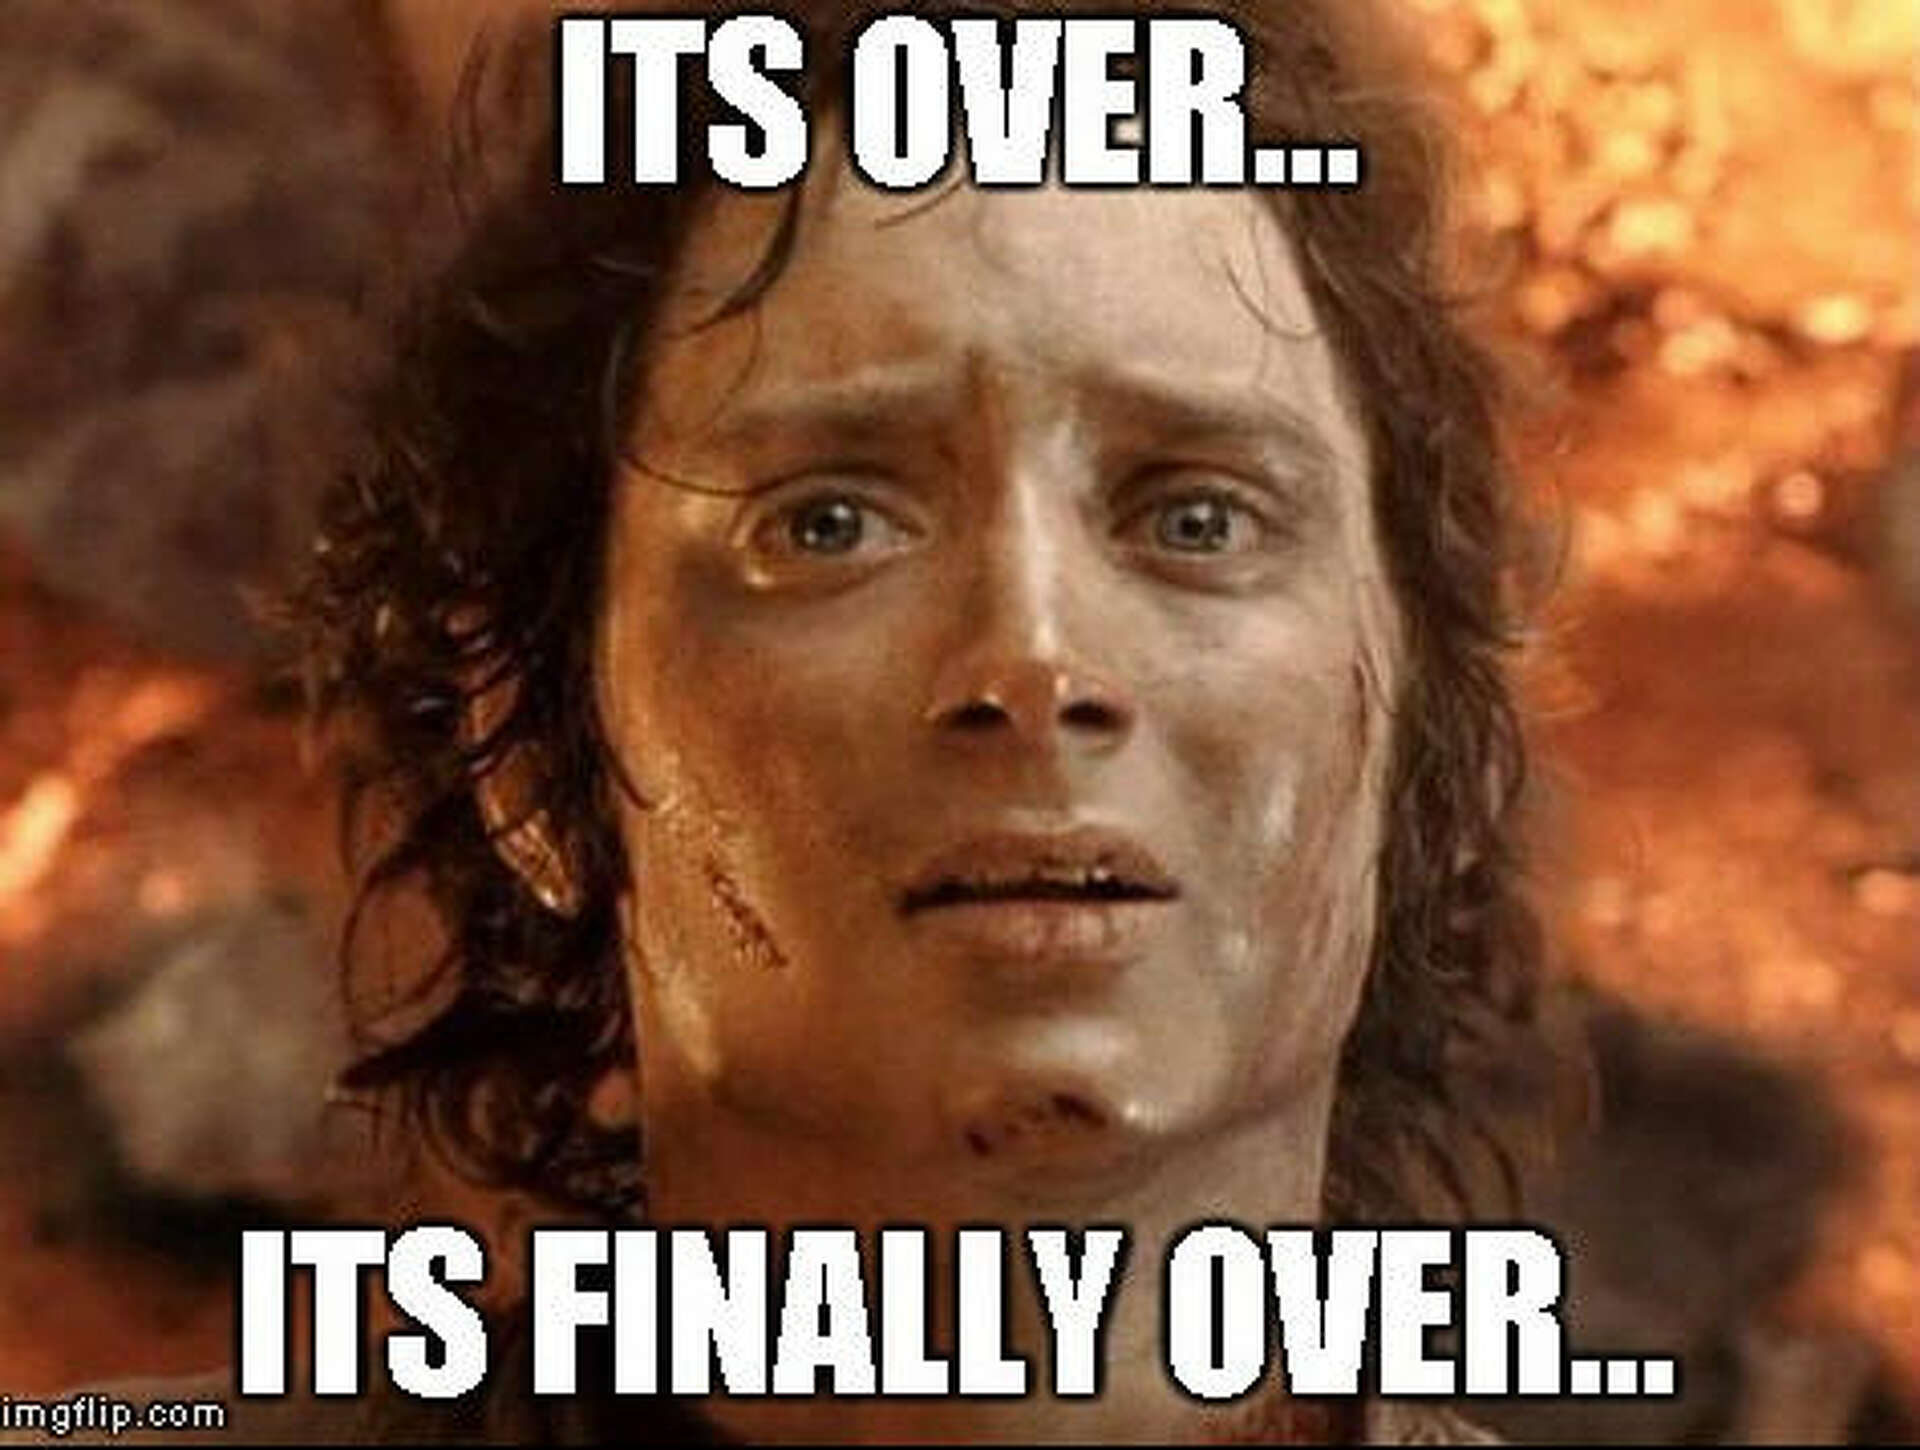